## NASA Frontier Development Lab - Disaster Prevention, Progress and Response (Floods)

Floods are one of the most dangerous natural disasters worldwide. All regions can be affected by flooding events and, with the increased variability in weather patterns due to global warming, this issue is likely to become even more prelevant. The speed at which flooding events can occur, and difficulties in predicting their occurrance, create huge logistic problems for both governmental and non-governmental agencies. Over the past 10 years, floods have caused on average 95 deaths a year in the US alone, making them the deadliest weather related phenomenon. Worldwide, floods cost in excess of 40 Billion dollars per year, impacting property, agriculture and the health of individuals.

Throughout the duration of the project, we collaborated with United States Geological Survey (USGS), a scientific agency within the US Department of the Interior. The objective of this organization is to study the landscape of the US and provide information about its natural resources and the natural hazards that affect them. Currently, hydrologists use physical models to help predict floods. These models require predictions to be carefully calibrated for each stream or watershed and careful consideration must be taken for dams, levees etc. Producing these models is extremely costly due to resource requirements. This limits the areas within the US that can avail of such systems to better prepare for flood events.

To predict the flood susceptibility of a stream area, the project is separated into two distinct problems.

**Monthly Model**

Predicting, per month, if a stream height will reach a predefined flood threshold. These flood thresholds are set by the National Oceanic and Atmospheric Administration (NOAA) and are location specific. Knowing which areas are susceptible to flooding may allow locations to better prepare for a flood event.

**Time to Peak Model**

Predicting the time taken for a stream/river to reach it's peak height. Following the occurrence of a major rain event, knowing how long it will take for a river to reach this height is vital in order to inform potentially affected individuals if and when they need to evacuate. This can help to reduce structural damage and loss of life during a disaster.

## The Data

This project focused on 6 US states over a period of 10 years. Data is sourced from ~900 gauge sites, between July 2009 and June 2019. Not all gauge sites had continuous historical data over the period, but all the available data for each site is utilized.

The 6 states were:

    -New Jersey
    -Nebraska
    -South Carolina
    -New York
    -South Dakota
    -Virginia
    
A primary reason for choosing these states, is that each exhibits similar climate and landscape. Focusing on similar geographies from a machine learning perspective ensures that the models produced could be generalized to similar regions and given assumed reduced variability in conditions, models that are likely to be more precise.

### Required datasets and providers:

**USGS**

The dataset provided by USGS is their Surface Water dataset. This consists of the height of a stream as measured by gauges for over 11,000 sites in the US. The data is updated every 15 minutes, with some locations having historical data for over 50 years. 

**PRISM**

The PRISM Climate Group provides climate observations across the whole of the US. This dataset is used to extract daily precipitation readings from the site locations for each day during the requested 10 year period.

**National Land Cover Database (NLCD)**

The NLCD database collected by the Landsat Satellite provides information such as land-use classification (urban, agriculture, forest, etc.), how well the land allows water to pass through it (impervious surface information) and tree cover. This dataset contains records updated every 5 years from 2006.

**National Hydrology Dataset Plus (NHDPlus)**

NHDPlus is a geo-spatial hydrologic framework dataset associated with USGS. The features used from this dataset are the catchment and drainage area characteristics at the stream site locations. 

**Flooded Locations And Simulated Hydrographs Project (FLASH)**

FLASH is a database containing information about flood events within the US. The information extracted from this dataset is the time taken for a river to reach its peak height after a major rain event.

**NOAA**

NOAA is a US governmental agency for monitoring and preserving the climate and environment. The data provided by NOAA relates to flood level thresholds for locations across the US. These thresholds consist of four warning stages and the river height for a given location that causes them to reach these levels. The four warning stages are:

|Warning |  Meaning                                                                                     |
|--------|-------                                                                                     |
|Action  |	Mitigation action needs to be taken in order to prepare for possible hydrological activity|
|Flood	 |  The river height poses a threat to lives, property and businesses|
|Moderate| 	Some inundation of roads or buildings. A flood warning should be released|
|Major	 |  Extensive inundation of roads and buildings. Considerable evacuations of areas may occur|


A more indepth discussion on these datasources can be found within the whitepaper corresponding to this notebook.

### Downloading the data

As some of the required datasets are particularly large, they are not contained within the data directory of this github repo. The README file associated with this notebook contains information explaining how to download all the required datasets.

## Load Required Libraries and Python Functionality

#### Load relevant Python functionality


 - Data manipulation functions
 - Plotting functionality
 - Scoring functionality and machine learning models

In [1]:
// Load embedPy to allow access to python functionality
\l p.q

np:.p.import[`numpy]
gp :.p.import[`geopandas]
train_test_split:.p.import[`sklearn.model_selection]`:train_test_split

plt:.p.import[`matplotlib.pyplot]

precision_recall_curve :.p.import[`sklearn.metrics]`:precision_recall_curve
average_precision_score:.p.import[`sklearn.metrics]`:average_precision_score
RandomForestClassifier :.p.import[`sklearn.ensemble]`:RandomForestClassifier
XGBClassifier          :.p.import[`xgboost]`:XGBClassifier

#### Load relevant libraries and scripts

 - Load the machine learning toolkit
 - Load flood data and associated code

In [2]:
\l ml/ml.q 
.ml.loadfile`:init.q

\l ../floods.q
.fld.loadfile`:init.q

sys:1: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.


## Data Preprocessing

Due to the variety of data sources and datasets used, preprocessing the data is of critical importance. This step ensured that feature engineering completed later in the pipeline is more seamless. 

In [3]:
// Utility functions

del:{![x;enlist (=;y;z);0b;`symbol$()]} / Functional delete
conv7_fn:{`$$[7=count x;"0",;]x}        / Prepend sites with 7 numbers with a 0

The following are the operations taken on the data at this stage:

1. Any stream-site names containing less than 8 values is prepended with 0's to ensure consist lengths. Rows containing nulls or infinities are removed from the datasets as these cannot be passed to machine learning algorithms.
2. A column denoting the index of each location in the NOAA threshold dataset is added, this is used for nearest neighbours calculations later in this notebook

In [4]:
precip:del[precipall;`ppt;0n]
maxht:update conv7_fn each site_no from del[max_ht_str;`height;neg[0w]]

warning:update nn:i from warnings

3. Add a column indicating for a given record which of the NLCD datasets is to be joined to the dataset.
    - The precipitation dataset is binned into the years, 2006, 2011 and 2016.
    - This binned information is added to the precipitation dataset

In [5]:
nlcdyear:{$[x<2011;6;x<2016;11;16]}each `year$precip[`date]

precip:update year:nlcdyear from precip

## Feature Engineering

Given the available data, it is possible to split the information into three distinct datasets

1. Ungauged basin: Information available at sites that do not contain stream gauge or future forecasting information. This data is limited to land use, past rainfall and upstream information.


2. Gauged basin: This dataset incorporates all information contained within the ungauged basin dataset, in addition to this it also contains stream gauge information. The stream gauge information includes previous river heights and lagged/aggregated flooding information.


3. Perfect Forecasts: This dataset includes all information contained within the gauged basin dataset. In addition, it includes rainfall information around the time of an event.

### Seasonality information and data restrictions

Seasonal Information plays an important role when predicting if an area will flood and how long this will take. 

 - This seasonality is captured by extracting the month that an event occurred, followed by a sine and cosine transformations of the month, creating columns named `sin_t` and `cos_t` respectively. 
 - The latitude and longitude of the stream sites are also represented by various sine and cosine decompositions of their coordinates.

In [6]:
pi:acos -1

precip:`date xasc update month:`mm$date from precip
precip:update cos_t:cos 2*pi*month%12,sin_t:sin 2*pi*month%12 from precip

precip:update x:cos(lat)*cos(long),y:cos(lat)*sin(long),z:sin(lat) from precip

###  Upstream, previous, windowed, and lagged features

Some of the most important information which can be extracted from the dataset include:

1. Upstream features (for example rainfall and stream/river height) which may provide early warnings for high volumes of water moving down-stream
2. Previous rainfall and stream/river height at a location up to a number of days before the event.
3. Windowed historical information which gives macro information about the system, this can include the maximum moving average rainfall in a location over a given time period for example .
4. Lagged features which provide historical information about the behaviour of the system (in this case an individual site).

For ease of implementation, the creation of these features within this white paper are wrapped within the macro function `addFeat`.

For clarity the following are the inputs to the functions `addFeat`:

**addFeat [x ; y ; z ; col ; d; fnc]**

- `x`    table that's being updated
- `y`    how many values to calculate (integer list)
- `z`    column to apply the function to (symbol)
- `col`  new column name (symbol)
- `d`    dictionary of where, groupby and type of functional statement being used
- `fnc`  function to be applied to the grouped column


In [7]:
colname:{enlist`$string[y],"_",string[x],"_",string[z]} // Create new column name
max_mavg:{(max;(mavg;y;x))}                             // Calculate maximal moving average
prv:{(xprev;y;x)}                                       // Calculate value of lagged features

// Applies functions to appropriate columns and rename columns appropriately
applyFunc:{[x;y;z;b]raze{[x;y;z;b]colname[x;y;z]!enlist b[x;z]}[z;y;;b]each raze x}

// upstream, previous, windowed and lagged extraction function
addFeat:{[x;y;z;col;d;fnc] d[`w][x;d`wh;d`gr;$[1<count[z];raze;]applyFunc[y;col;;fnc]each z]}

#### Upstream Values

Using the `addFeat` function, upstream information can be obtained. This is possible as the id numbers for each site consist of the initial two digits which denote the basin catchment. The remaining digits are ascending values based on the location of gauges along the stream. A functional update is applied to the tables, grouping by basin catchments and date. This enables the upstream precipitation and height values to be extracted.

In [8]:
catch_site:((';#);2;($:;`site_no))           /Grouping site numbers by catchment, using the first 2 digits
site_date :`site_no`date!(catch_site;`date)
dict:`w`wh`gr!(!;();site_date)

upstr_ppt   :addFeat[precip;1;`ppt;`upstr;dict;prv]
upstr_height:addFeat[maxht;1;`height;`upstr;dict;prv]

#### Previous rainfall and stream height

The `addFeat` function is also used to find the rainfall and heights for both the current and upstream locations for the 10 days prior to an event. This is achieved by grouping the tables by site number, allowing the previous precipitation and height values to be obtained. 

In [9]:
dict[`gr]:site:(enlist `site_no)!enlist `site_no

prev_rain:addFeat[upstr_ppt;enlist 1_til 10;`ppt`upstr_ppt_1;`prev;sited:dict;prv]
all_height:addFeat[upstr_height;enlist 1_til 10;`height`upstr_height_1;`prev;dict;prv]

### Use-case specific features

All of the features calculated above are applicable in each of the use-cases, however both the monthly and time-to-peak models also require more bespoke features to be calculated

### Monthly Model

The following steps are completed to extract additional features for the monthly model

1. The maximal moving average rainfall is extracted at current and previous upstream sites over different time windows prior to the date in question(1 - 15 day windows). This is achieved by grouping the data by month and site number, and applying the `addFeat` function, denoting the size of the windows being applied

In [10]:
dict[`gr]:(`date`site_no)!(($;enlist`month;`date);`site_no)

all_rain:addFeat[prev_rain;enlist 1_til 15;`ppt`upstr_ppt_1;`window;dict;max_mavg]

2. The first day of each month is selected as the point of reference for the monthly data, this allows for all  information from the previous month to be incorporated.

In [11]:
height_data:update date:"m"$date from select from all_height where 1=`dd$date
rain_data  :update date:"m"$date from select from all_rain   where 1=`dd$date

3. The height and rain data are joined for each site and date to create an initial monthly dataset

In [12]:
monthly_data:height_data ij`site_no`date xkey rain_data

### Time to Peak Model

The hours leading up to a flash flood event can provide important information regarding how quickly the height of a stream is moving. This information can be incredibly important in allowing for prediction of the time it will take for the stream to reach its peak height.

For construction of the time to peak models, the following steps are taken to produce appropriate features:

1. The FLASH dataset (`peak`) is joined to the daily height and rain datasets produced previously

In [13]:
peak_data:(peak ij`date`site_no xkey prev_rain)ij`date`site_no xkey all_height

2. The temporal information within the FLASH dataset is converted from UTC such that all times are consistent with the USGS stream data.

In [14]:
// The date associated with each site 
site_date:flip value flip 0!select date by distinct site_no from peak_data

// The timezone (unk) information for each site is obtained from the gauges hdb (str)
time_zone:raze{
  dd:x[1];si:x[0];
  select `$first site_no,`$first unk from str where date=first dd,si=`$site_no}each site_date

// The time-zone information is joined to the peak dataset
peak_data:peak_data ij`site_no xkey time_zone

// Define a function to modify the time-zone based on extracted information from gauges hdb
change_zone:{tz:x[1];tm:x[0];$[tz=`EDT;tm-04:00;tz=`CDT;tm-05:00;tm-06:00]}

// A time zone change is applied to the relevant time columns in dataset
peak_data[`start_time]:change_zone each flip peak_data`start_time`unk
peak_data[`end_time]  :change_zone each flip peak_data`end_time`unk
peak_data[`peak_time] :change_zone each flip peak_data`peak_time`unk

3. The date column is updated to account for changes in date arising as a result of the conversion from UTC

In [15]:
peak_data[`date]:`date$peak_data`start_time

4. Maximal moving averages for windows of time up to 2 days prior to the event are extracted:

    - Functions are produced in order to extract the appropriate date range from the dataset, indicate the where clause to be applied, and create a dictionary to be pased to the `addFeat` function
    - Maximal moving average precipitation over 2, 4, 8, 12 and 48 hour windows are taken for two days prior to an event.
    - The newly created features are added to the dataset and infinities are removed

In [16]:
// The date range of interest 
range:{(within;x;(,;(+;(-:;2);y);y))}
// The where clause to be applied 
wh:{(range[`date;x[1]];range[`datetime;x[2]];(=;enlist x[0];($;enlist`;`site_no)))}
// Dictionary to be passed to the addFeat function
dict:{`w`wh`gr!(?;wh x;0b)}

window_ht_prev:{addFeat[str;enlist 2 4 12 48;`height;`window_prev;dict x;max_mavg]
  }each flip peak_data[`site_no`date`start_time]

peak_data:peak_data,'raze window_ht_prev
peak_data:del[peak_data;`window_prev_height_2;neg[0w]]

5. Information is extracted relating to projected rainfall for the next 3 days:

    - A function defining the where clause is created, along with the dictionary to be passed to the `addFeat` function.
    - Rainfall information for the 3 days following an event of interest is then extracted.
    - These derived features are incorporated into the dataset

In [17]:
wh:{((within;`date;(,;y[1];(+;y[1];x)));(=;enlist y[0];`site_no))}
dict:{`w`wh`gr!(?;wh[x;y];0b)}

rain_pred:{addFeat[all_rain;enlist 1_til x;`ppt`upstr_ppt_1;`fut_window;dict[x;y];max_mavg]
  }[3]each flip peak_data[`site_no`date]

peak_data:peak_data,'raze rain_pred

A mapping of the extracted features and the datasets with which they are associated, is as follows

|Feature  |Associated Dataset |
|---------|-------------------|
|previous rainfall|ungauged, gauged, perfect forecasts|
|previous height|gauged, perfect forecasts|
|moving precip averages per month| perfect forecasts|
|previous windowed height| gauged,perfect forecasts|
|predicted precip rain for time to peak| perfect forecasts|


## Target Data

### Monthly Models

The target chosen for the monthly model task is extracted from the NOAA flood warning dataset. The target itself indicates if for a given month a flood stage warning is issued, thus the model which is to be produced must be a binary classifier. The flood warnings are split into 4 stages,

1. Action
2. Flood
3. Moderate
4. Major

In order to ensure that a sufficient number of positive targets are present within the data, the 'flood' level was chosen as major events are less common.

Given that the sites at which NOAA flood warnings are calculated and the location of gauge sites are not necessarily coincident, the latitude and longitude of the sites are used to complete a nearest neighbours join of the datasets, thus making a consistent dataset.

The steps taken to create the appropriate targets are as follows:

1. A nearest neighbours search is completed to map NOAA locations to stream sites based on latitude and longitude values :

    - A list denoted by `wlatl` is created, this indicates the latitudes and longitudes of the NOAA warning locations and gauge sites respectively
    - A nearest neighbours algorithm based on a kd-tree is used to extract the closest NOAA warning location to each gauge site.
    - A keyed table indicating the nearest NOAA warning location to each gauge site is produced

In [18]:
wlatl:raze each warning[`Latitude`Longitude],'gauges[`dec_lat_va`dec_long_va]

tabw:kd.buildtree[wlatl;2]
gauge_val:count[warning]+til count gauges
nnwarn:kd.nns[;tabw;(count[warning]#0),count[gauges]#1;flip wlatl;`edist]each gauge_val

joins:([site_no:gauges`site_no]nn:nnwarn[;0];ndw:nnwarn[;1])

2. The maximum height dataset `maxht` defined during the execution of the load script is joined to the flood warnings table.

In [19]:
floodlvl:(maxht ij joins)lj`nn xkey warning

floodlvl[`Action`Moderate`Flood`Major]:"F"$'floodlvl[`Action`Moderate`Flood`Major]

3. A table indicating the number of times a stream has reached each flood warning level is created. This is done by comparing the streams height to the heights provided by NOAA which denote each of the warning levels.

In [20]:
10#threshold:0!select 
                first Action,first Flood,first Moderate,first Major,
                no_Action:count where height>Action,no_Flood:count where height>Flood,
                no_Mod:count where height>Moderate,no_Major:count where height>Major 
                by site_no,"m"$date from floodlvl

site_no  date    Action Flood Moderate Major no_Action no_Flood no_Mod no_Major
-------------------------------------------------------------------------------
01303500 2009.07 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2009.08 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2009.09 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2009.10 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2009.11 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2009.12 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2010.01 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2010.02 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2010.03 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2010.04 9.8    10.1  11.1     13.1  0         0        0      0       


4. Filter out any sites that indicate 28 days of flooding in a month occurred. This is done based on a desire to prioritise events which are not commonplace.

5. Create a binary classification target indicating if a flood warning level is reached


In [21]:
threshold:select from threshold where no_Flood<28

threshold[`target]:threshold[`no_Flood]>0

### Time to Peak Model

To produce a target for the time to peak model the FLASH dataset is used. This dataset provides information pertaining to how long it will take a gauge location to reach it's peak height following a major rainfall event. To get this information and create a machine learning task the following steps are taken:

1. The start time of an event is subtracted from the time that the stream reached it's peak height, this is then converted to the number of hours elapsed.
2. A binary classification task is produced by setting a 3.5 hour time difference between a rainfall event and peak stream height as the threshold for an event of interest. This time definition was set based on discussion with hydrologists at USGS.

In [22]:
peak_data[`delta_peak]:(peak_data[`peak_time]-peak_data[`start_time])*24

peak_data[`target]:peak_data[`delta_peak]<3.5

## Addition of final features

### Addition of the characteristics tables 

1. The basin characteristics and NLCD landcover datasets are joined to produce a stream characteristics (`stream_char`) table. This provides information about the geography near to site locations. 

2. This table is then joined to the peak and monthly datasets based on site number to create `all_peak_data` and `monthly_stream_data` tables.

3. The threshold information is then joined to the monthly data by site number and date to allow for the addition of lagged flood information in the next section.

In [23]:
stream_char:nlcd ij`site_no xkey basin

all_peak_data:peak_data ij`site_no`year xkey stream_char
monthly_stream_data:monthly_data ij`site_no`year xkey stream_char

all_monthly_data:monthly_stream_data ij`site_no`date xkey threshold

### Lagged features

For the monthly model, historic lagged information is added to the dataset:
 1. The `addFeat` function is used to extract information pertaining to whether a specific site has flooded in the last month or at the same time the year prior. 
 2. The number of times per month the flood warning level is reached at each site location is also extracted to produce the `tgts` table. 
 3. This information can then used to obtain a moving average for target data such that the `lagged_target_all` column is produced.

In [24]:
all_monthly_data:addFeat[all_monthly_data;enlist 1 12;`target;`lagged;sited;prv]

tgts:value exec no_Flood by site_no from all_monthly_data

all_monthly_data[`lagged_target_all]:raze{count[x]mavg raze x}each tgts

The above features are included in both the gauged and perfect forecasts datasets.

## Train-Test Split

### Preparation

Prior to the application of a train test split on the data, rows containing null values are removed from the dataset as these cannot be passed to machine learning algorithms.

In [25]:
del_null:{where not any each null x}          // Find rows containing null data

cleaned_monthly:all_monthly_data[del_null all_monthly_data]
cleaned_peak:   all_peak_data[del_null all_peak_data]

The appropriate feature columns for the monthly and time to peak models are extracted for each of the three datasets outlined earlier in the notebook:

1. Ungauged
2. Gauged
3. Perfect Forecasts


The feature columns to be included for each of these datasets mentioned earlier are mentioned in `columns_to_include.q` under the following headings:

1. ungauged_cols
2. gauged_cols
3. perfect_forecast_cols

These columns omit any information which would be considered 'leakage' including target columns or any columns from which the target could be derived.

The columns for monthly (M) and time to peak (P) examples for each dataset are extracted using the `fnd_col` function as shown below.

In [26]:
fnd_col:{x where x in y}

ungauged_colsM:         fnd_col[ungauged_cols;cols cleaned_monthly]
gauged_colsM:           fnd_col[gauged_cols;cols cleaned_monthly]
perfect_forecast_colsM: fnd_col[perfect_forecast_cols;cols cleaned_monthly]

ungauged_colsP:         fnd_col[ungauged_cols;cols cleaned_peak]
gauged_colsP:           fnd_col[gauged_cols;cols cleaned_peak]
perfect_forecast_colsP: fnd_col[perfect_forecast_cols;cols cleaned_peak]

M| `month`cos_t`sin_t`elv`imp`CatAreaSqKm`WsAreaSqKm`CatAreaSqKmRp100`WsAreaS..
P| `month`cos_t`sin_t`elv`imp`CatAreaSqKm`WsAreaSqKm`CatAreaSqKmRp100`WsAreaS..


The following cell outlines a framework by which the appropriate datasets can be extracted for each of the monthly and time to peak tasks

1. Dictionaries containing the appropriate datasets for each task are defined
2. The function `split_dict` is created which takes a table and `M`/`P` as input and returns the appropriate data as a matrix

In [27]:
show ungauge: `M`P!(ungauged_colsM;ungauged_colsP)
gauge:   `M`P!(ungauge[`M],gauged_colsM;ungauge[`P],gauged_colsP)
forecast:`M`P!(gauge[`M],perfect_forecast_colsM;gauge[`P],perfect_forecast_colsP)

split_dict:{(!). flip(
  (`ungauged;flip x[ungauge[y]]);
  (`gauged;flip x[gauge[y]]);
  (`forecast;flip x[forecast[y]]))}

### Monthly Model

When splitting the data for this model, it was decided that no time leakage should occur between the training and test sets (e.g. the training set contained information from 2009 to 2017, while the test set contained the remaining years).

This ensures that the models are tested in a scenario similar to how they would be used in the real world .i.e training on currently available information and testing on new information as it becomes available. 

The training set contains 80% of the data while the testing set consists of the remaining 20%. The `split_dict` function defined previously is used to produce the training data.

In [28]:
// The cutoff dataset is produced and date defined at which the datasets are to be cutoff
cutoff:update cutoff_date:min[date]+floor 0.8*max[date]-min[date] by site_no from cleaned_monthly

// Data and targets from the dataset are extracted
XtrainMi:select from cutoff where date<cutoff_date
XtestMi :select from cutoff where date>=cutoff_date
ytrainM :exec target from cutoff where date<cutoff_date
ytestM  :exec target from cutoff where date>=cutoff_date

// From the master training and testing datasets the appropriate information for the monthly data are extracted
XtrainM:split_dict[XtrainMi;`M]
show XtestM:split_dict[XtestMi;`M]

ungauged| 6i  -1f          1.224647e-16  59f   25.99038    2.2941  72.4599  0..
gauged  | 6i  -1f          1.224647e-16  59f   25.99038    2.2941  72.4599  0..
forecast| 6i  -1f          1.224647e-16  59f   25.99038    2.2941  72.4599  0..


### Time to Peak Model

The following histogram displays sites which produced a flash flood event within the range of each bin. This highlights the uneven distribution of targets across sites and thus explains the need for a more complex data splitting methodology.

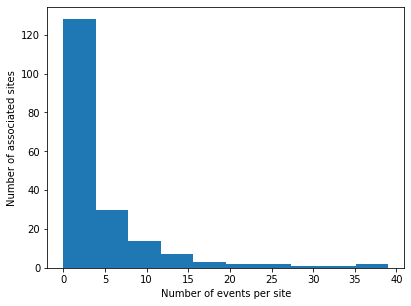

In [29]:
sites:0!select sum target by site_no from cleaned_peak
plt[`:hist][sites`target];
plt[`:xlabel]["Number of events per site"];
plt[`:ylabel]["Number of associated sites"];
plt[`:show][];

The splitting of this dataset is slightly more involved. In order to test generalization to new areas the data is split such that sites cannot appear in both the training and testing sets. In addition to this, given the uneven distribution of events in each site the data is stratified such that the training and testing sets contain sites which have similar levels of flood activity.

In [30]:
// The number of events associated with each bin of the dataset is set
bins:0 5 15 25.0

// The target data is split into the associated bin
y_binned:bins bin`float$sites`target

// Using embedPy, site numbers and targets are stratified into an 80-20 train-test split of the data
tts:train_test_split[sites[`site_no];sites[`target];`test_size pykw 0.2; `random_state pykw 607;
    `shuffle pykw 1b;`stratify pykw y_binned]`;

// The cleaned_peak data is updated such that a flag indicating training/testing is added
cleaned_peak[`split]:`TRAIN
peak_split:update split:`TEST from cleaned_peak where site_no in`$tts[1]

As in the Monthly model, the `split_dict` function is used to appropriately split the dataset

In [31]:
XtrainPi:select from peak_split where split=`TRAIN
ytrainP:exec target from peak_split where split=`TRAIN
XtestPi:select from  peak_split where split=`TEST
ytestP:exec target from peak_split where split=`TEST

XtrainP:split_dict[XtrainPi;`P]
show XtestP:split_dict[XtestPi;`P]

ungauged| 7i  -0.8660254   -0.5          246f  12.16933   4.0455  47.2707  0...
gauged  | 7i  -0.8660254   -0.5          246f  12.16933   4.0455  47.2707  0...
forecast| 7i  -0.8660254   -0.5          246f  12.16933   4.0455  47.2707  0...


## Model Building and Evaluation

Thoughout the course of this work a wide variety of models were tested including Neural Networks, however for the sake of this notebook, only models and results from an eXtreme Gradient Boost (XGBoost) and random forest classifier are presented. These models were chosen due to their ability to deal with complex, imbalanced datasets. A more indepth discussion of these models can also be found in the associated whitepaper.

The following cell outlines a function used to fit both a Random-Forest classifier and XGBoost model. This function returns a fitted model for each algorithm.

In [32]:
build_model:{[Xtrain;ytrain;dict]
 rf_hyp_nms:`n_estimators`random_state`class_weight;
 rf_hyp_vals:(dict`rf_n;0;(0 1)!(1;dict`rf_wgt));
 rf_clf:RandomForestClassifier[pykwargs rf_hyp_nms!rf_hyp_vals][`:fit][Xtrain; ytrain];

 xgb_hyp_nms:`n_estimators`learning_rate`random_state`scale_pos_weight`max_depth;
 xgb_hyp_vals:(dict`xgb_n;dict`xgb_lr;0;dict`xgb_wgt;dict`xgb_maxd);
 xgb_clf: XGBClassifier[pykwargs xgb_hyp_nms!xgb_hyp_vals][`:fit][np[`:array]Xtrain; ytrain];
 
 `random_forest`XGB!(rf_clf;xgb_clf)}

These models are used in the results section below in conjunction with the function `pr_curve` to test their performance on the training set. This function is used both to visulaize the results in the form of a precision-recall curve and also to provide important model evaluation metrics.

**pr_curve[ xtest ; ytest ; dict ]**

* `xtest` = matrix of feature values
* `ytest` = list of targets 
* `dict`  = dictionary of fitted models produced by `build_model` above

The output information from this function is as follows

1. Overall accuracy of the model 
2. Mean-Class accuracy which is a 'fairer' accuracy metric
3. Classification report outlining overall and class based precision, recall and f1-score
4. The precision-recall curves for each model and the area under the curve associated with each 

## Results

The scores and graphics in the results below are separated based on the three datasets created and sub divided into the monthly and time to peak models.

Following display of the graphics and scores, a summary of the results for each section are provided.

### Ungauged Prediction 

#### Monthly Model


Accuracy for random_forest: 0.9380757


Meanclass accuracy for random_forest: 0.8382345


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9424622 0.9939699 0.967531  13101  
1        | 0.7340067 0.2152024 0.3328244 1013   
avg/total| 0.8382345 0.6045861 0.6501777 14114  

Accuracy for XGB: 0.9197959


Meanclass accuracy for XGB: 0.69065


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9512177 0.9629799 0.9570627 13101  
1        | 0.4300823 0.3613031 0.3927039 1013   
avg/total| 0.69065   0.6621415 0.6748833 14114  


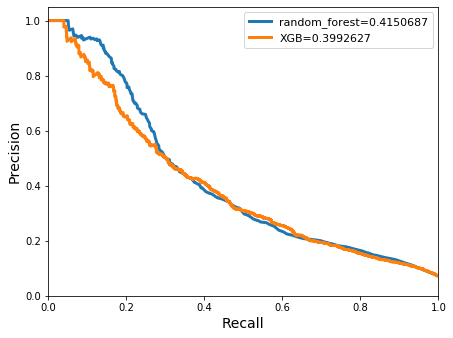

In [33]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(200;1;8;200;.2;15;7)

models:build_model[XtrainM`ungauged;ytrainM;dict]

pltU1:pr_curve[XtestM`ungauged;ytestM;models]

#### Time to Peak Model


Accuracy for random_forest: 0.7330896


Meanclass accuracy for random_forest: 0.7312101


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7336066 0.9572193 0.8306265 374    
1        | 0.7288136 0.2485549 0.3706897 173    
avg/total| 0.7312101 0.6028871 0.6006581 547    

Accuracy for XGB: 0.7751371


Meanclass accuracy for XGB: 0.7474176


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7995227 0.8957219 0.8448928 374    
1        | 0.6953125 0.5144509 0.5913621 173    
avg/total| 0.7474176 0.7050864 0.7181275 547    


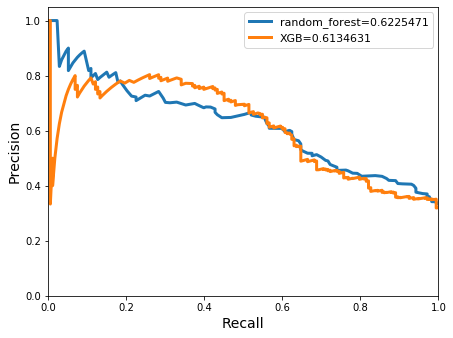

In [34]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(220;1;17;340;.01;1.5;3)

models:build_model[XtrainP`ungauged;ytrainP;dict]

pltU2 :pr_curve[XtestP`ungauged;ytestP;models]

### Gauged Prediction

#### Monthly Model


Accuracy for random_forest: 0.9422559


Meanclass accuracy for random_forest: 0.9000509


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9439867 0.9969468 0.9697442 13101  
1        | 0.8561151 0.2349457 0.3687064 1013   
avg/total| 0.9000509 0.6159463 0.6692253 14114  

Accuracy for XGB: 0.9332578


Meanclass accuracy for XGB: 0.7507384


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9559055 0.9729792 0.9643668 13101  
1        | 0.5455712 0.4195459 0.4743304 1013   
avg/total| 0.7507384 0.6962625 0.7193486 14114  


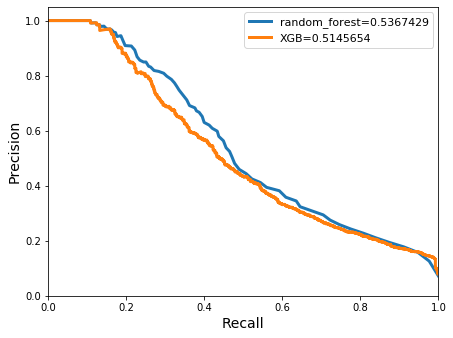

In [35]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;16;8;100;0.2;16;9)

models:build_model[XtrainM`gauged;ytrainM;dict]

pltG1:pr_curve[XtestM`gauged;ytestM;models]

#### Time to Peak Model


Accuracy for random_forest: 0.7367459


Meanclass accuracy for random_forest: 0.763421


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7309237 0.973262  0.8348624 374    
1        | 0.7959184 0.2254335 0.3513514 173    
avg/total| 0.763421  0.5993478 0.5931069 547    

Accuracy for XGB: 0.7842779


Meanclass accuracy for XGB: 0.7650789


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7990654 0.9144385 0.8528678 374    
1        | 0.7310924 0.5028902 0.5958904 173    
avg/total| 0.7650789 0.7086643 0.7243791 547    


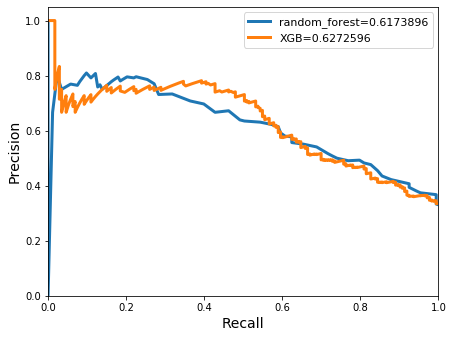

In [36]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;350;0.01;1.5;3)

models:build_model[XtrainP`gauged;ytrainP;dict]

pltG2 :pr_curve[XtestP`gauged;ytestP;models]

### Perfect Forecast

#### Monthly Model


Accuracy for random_forest: 0.9448066


Meanclass accuracy for random_forest: 0.9130627


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9462553 0.9971758 0.9710484 13101  
1        | 0.8798701 0.2675222 0.4102952 1013   
avg/total| 0.9130627 0.632349  0.6906718 14114  

Accuracy for XGB: 0.9471447


Meanclass accuracy for XGB: 0.8045102


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9695219 0.9736661 0.9715896 13101  
1        | 0.6394984 0.6041461 0.6213198 1013   
avg/total| 0.8045102 0.7889061 0.7964547 14114  


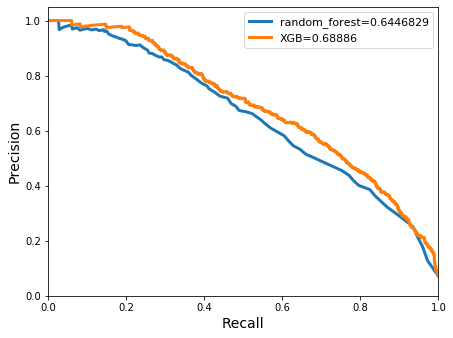

In [37]:
dict:`rf_n`rf_wgt`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;15;100;0.2;15;7)

models:build_model[XtrainM`forecast;ytrainM;dict]

pltP1:pr_curve[XtestM`forecast;ytestM;models]

#### Time to Peak Model


Accuracy for random_forest: 0.7550274


Meanclass accuracy for random_forest: 0.7668274


class    | precision recall    f1_score support
---------| ------------------------------------
0        | 0.751046  0.959893  0.842723 374    
1        | 0.7826087 0.3121387 0.446281 173    
avg/total| 0.7668274 0.6360159 0.644502 547    

Accuracy for XGB: 0.7440585


Meanclass accuracy for XGB: 0.7027966


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.8031088 0.828877  0.8157895 374    
1        | 0.6024845 0.5606936 0.5808383 173    
avg/total| 0.7027966 0.6947853 0.6983139 547    


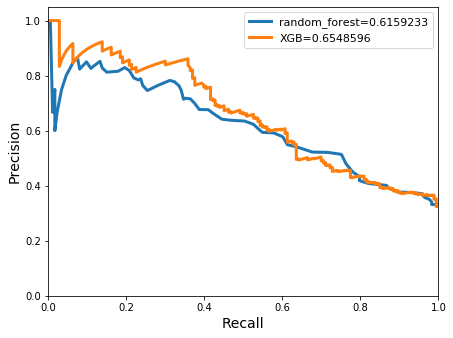

In [38]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;300;0.01;2.5;3)

models:build_model[XtrainP`forecast;ytrainP;dict]

pltP2 :pr_curve[XtestP`forecast;ytestP;models]

### Scoring Summary

**Ungauged Models**

*Monthly*

The accuracies of both classifiers in the monthly model were relatively high in this case. Random forests achieved a slightly higher score of 0.938. The meanclass accuracy was lower for both classifiers, ranging from ~0.7-0.84 in the random forests and XGBoost respectively. However, considering that the class distribution was extremely imbalanced, the accuracy is an unreliable metric to evaluate the models fairly. Both classifiers returned low precision and recall scores when evaluating the positive class, indicating that the models were not adept at discerning flood events. Low scores of ~0.4 were also seen in the precision-recall curves for both classifiers.

*Time to Peak*

XGBoosts achieved both a higher accuracy of 0.78 and a more stable precision recall ratio, 0.7 to 0.51, for the positive class when compared with random forests. This indicates that a relatively large amount of flood events occuring under the 3.5 hour threshold were being identified by the model. The meanclass accuracies for both classifiers were similar at ~0.75. The area under the precision-recall curve were also seen to be comparable for both classifiers.

**Gauged Models**

*Monthly*

Improvements in both the accuracy and meanclass accuracy were evident in the gauged models when compared to the ungauged example. In this case, higher accuracies were achieved by the random forest classifier. The meanclass accuracy also performed better at 0.9 when compared with the XGBoost classifier result of 0.75. Although still low, a slightly improved balance between the precision and recall scores, 0.54 to 0.42, for the positive class was reached by the XGBoost. The area under the precision-recall curve improved in both classifiers to 0.51 (XGBoost) and 0.54 (random forests) from the previous ungauged model.

*Time to Peak*

The accuracy and meanclass accuracy achieved with the gauged datasets were very similar to the results obtained in the ungauged model. This in conjunction with similarities to the precision and recall scores indicates that the addition of previous stream/river heights does not impact the models. The areas under with the precision-recall curves however, were also similar when compared with the previous models curves.

**Perfect Forecast Models**

*Monthly*

Similar accuracy results were seen between the random forests and XGBoost with results on the order of 0.945. The random forest classifier achieved a greater meanclass accuracy score of 0.91 compared with that of XGBoosts 0.8. Precision and recall scores for the positive class were also high at ~0.62 for both metrics. However the random forest classifier produced a high imbalance between the precision and recall scores which were 0.88 and 0.27 respectively. Both precision-recall curves improved from the previous gauged model, achieving areas of 0.69 and 0.64 for XGBoost and the random forest classifier respectively.

*Time to Peak*

A slight decrease in accuracy occured in both classifiers compared with previous models, although an improved  balance between the precision and recall scores of 0.6 and 0.56 were seen for the XGBoost. The area under the precision-recall curves increased slightly when compared to the the previous models results, reaching scores of 0.65 for the XGBoost and and 0.62 for the random forests classifiers.

### Feature Significance

There is also a lot to be learned from determining which features contribute to predicting the target for a model. Such analysis could allow organizations to prioritise the information which is taken into account when making decisions around resourcing and funding.

To find the features which deemed statistically significant to prediction of the target, the function `ml.fresh.significantfeatures` from the machine learning toolkit is used. The top 15 features in both the monthly and time to peak models are found here using `ml.fresh.ksigfeat[x]`.

The cell below defines some functionality used for the evaluation of both models:

In [39]:
title:{"The top 15 significant features for ",x," predictions are:"}
nums :{string[1+til x],'x#enlist". "}
kfeat:.ml.fresh.ksigfeat 15

#### Monthly Model

In [40]:
title["monthly"]
X_Month:flip forecast[`M]!cleaned_monthly[forecast[`M]]
y_Month:cleaned_monthly`target
3 cut`$nums[15],'string .ml.fresh.significantfeatures[X_Month;y_Month;kfeat]

"The top 15 significant features for monthly predictions are:"


1. lagged_target_all     2. window_ppt_1          3. window_ppt_2        
4. window_ppt_3          5. window_ppt_4          6. window_ppt_5        
7. window_ppt_6          8. window_upstr_ppt_1_1  9. window_upstr_ppt_1_2
10. window_upstr_ppt_1_3 11. window_upstr_ppt_1_4 12. lagged_target_1    
13. lagged_target_12     14. window_upstr_ppt_1_5 15. window_ppt_7       


#### Time to Peak Model

In [41]:
title["time-peak"]
X_t2p:flip forecast[`P]!cleaned_peak[forecast[`P]]
y_t2p:cleaned_peak`target
3 cut`$nums[15],'string .ml.fresh.significantfeatures[X_t2p;y_t2p;kfeat]

"The top 15 significant features for time-peak predictions are:"


1. WsAreaSqKmRp100       2. WsAreaSqKm            3. window_prev_height_48
4. prev_upstr_height_1_1 5. window_prev_height_12 6. prev_height_1        
7. WetIndexCat           8. prev_height_5         9. prev_height_4        
10. prev_height_6        11. prev_height_7        12. prev_height_2       
13. window_prev_height_4 14. prev_height_8        15. prev_height_3       


## Graphics 

#### Monthly Model

Using these results, it is also possible to build a map highlighting which areas are likely to be at risk of flooding on a month to month basis. This could be used by governmental bodies to prioritize funding in the coming weeks.

In [42]:
preds:last pltP1`model
newtst:update preds:preds from XtestMi
newt:select from newtst where date within 2018.01 2018.12m,preds=1
dfnew:.ml.tab2df newt
graphs:.p.get`AcledExplorer
graphs[`df pykw dfnew][`:render][];

**Note**

For clarity this uses a python function contained in the file `../code/graphics.p` from this directory. The use of interactive widgets in a JupyterQ through embedPy is limited in scope. More information and examples on using widgets in JupyterQ can be found on https://github.com/KxSystems/jupyterq/blob/master/examples/q_widgets.ipynb

#### Time to Peak Model

Given the information that has been extracted from above, a comparison between the predicted time that a stream will reach it's peak height is compared to the actual time of the peak height event. This is shown in the graphic below.

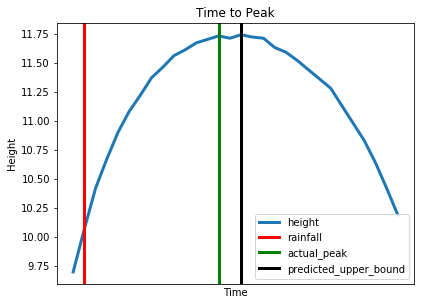

In [43]:
// The predictions for the ungauged model are extracted
pred:last pltU2`model

// For a specific site the start, peak and end times of an produced
pg:raze select site_no,start_time,end_time,peak_time from XtrainPi 
    where unk=`EDT,i in where pred=XtestPi`target,site_no=`02164110,
    target=1,delta_peak>2

// Define the parameters to be taken into account in plotting
rainfall   :`x_val`col`title!(pg[`start_time];`r;`rainfall)
actual_peak:`x_val`col`title!(pg[`peak_time];`g;`actual_peak)
pred_bound :`x_val`col`title!(03:30+pg[`start_time];`black;`predicted_upper_bound)

// The relevant information for each site at the time of a major rainfall event is extracted
graph:select from str where date within (`date$pg[`start_time];`date$pg[`end_time]), datetime
      within (neg[00:15]+pg[`start_time];[00:10]+pg[`end_time]),(pg`site_no)=`$site_no

// The stream height is plotted as a function of time
times  :graph`datetime
heights:graph`height
plt_params:`label`linewidth!(`height;3)
plt[`:plot][times;heights;pykwargs plt_params];

// Lines indicating relevant events are plotted
pltline:{
  dict:`color`label`linewidth!(x`col;x`title;3);
  plt[`:axvline][x`x_val;pykwargs dict];}

pltline each(rainfall;actual_peak;pred_bound);

plt[`:legend][`loc pykw `best];
plt[`:title]["Time to Peak"];
plt[`:ylabel]["Height"];
plt[`:xlabel]["Time"];
plt[`:xticks][()];
plt[`:show][];

## Conclusion

From the above results we could predict, with relatively high accuracy, whether an area was likely to flood or not in the next month. We could also produce a model to predict if a stream would reach its peak height within 3.5 hours.

For the monthly models, the future weather predictions played an important role in predicting whether an area would flood or not. Accuracy increased as the weather predictions and gauged information columns were added to the dataset. This corresponds with the results from the significant feature tests, where lagged_target information and the windowed rain volumes of the current month were deemed to be the most features for inclusion. For the majority of the models, the random forests classifier obtained high accuracy results, however this often coincided with imbalanced precision and recall scores. In some scenarios, high precision scores were achieved along with corresponding low recall, indicating that flooding events could be missed. Although XGBoosts didn't achieve as high accuracy, the precision and recall scores were much more balanced which is a favourable trait to have in this type of model when predicting complex events such as flooding. 

The opposite was true for the time to peak models, as previous rain and stream gauge information along with the basin characteristics were deemed to be the most significant features when predicting these values. Including additional information about the future predicted rainfall did not improve the accuracy of the results. The best results were obtained from the gauged model by the XGBoost classifier. Despite this, the perfect forecasts dataset achieved the best balance between the precision and recall of the positive class, compared with the ungauged model that favoured high precision alongside low recall scores. 

Both of these results are to be physically expected. In the case of the monthly prediction, information regarding future rainfall information is vital to predicting if an area will flood in the next month. Whereas in the case of a time to peak value, it would extremely unlikely that information about rainfall in the days following the peak height being reached would add any predictive power to the model.

Knowing the features that contribute to flood susceptibility and the length of time it takes for a river to reach its peak height, are important pieces of information to extract from the model. From this, organizations such as USGS can better prepare for flood events and understand how changing climates and placement of impervious surface can affect the likelihood of flooding.

The best results from the models above were obtained by continuously adjusting the hyper-parameters of the model. The unbalanced target data in the monthly model, meant that weighting the classes was an important feature to experiment with. This was particularly important when trying to obtain high precision and recall results. Between the two models, balance in the recall and precision was better for the XGBoost model.

---